In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from PIL import PILLOW_VERSION
from PIL import Image
from torch.utils.data import Dataset
import sqlite3
import random

import torch.utils.data as data
import torchvision.models as models
from torchvision import datasets, transforms, utils
from math import ceil

/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'resnet50.ipynb'

In [4]:
!pip install wandb -Uq

In [74]:
!wandb login --relogin 

^C
Traceback (most recent call last):
  File "/home/mdelabrassinne/anaconda3/envs/envDeepLearning/bin/wandb", line 5, in <module>
    from wandb.cli.cli import cli
  File "/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/wandb/__init__.py", line 26, in <module>
    from wandb import sdk as wandb_sdk
  File "/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/wandb/sdk/__init__.py", line 5, in <module>
    from .wandb_artifacts import Artifact  # noqa: F401
  File "/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/wandb/sdk/wandb_artifacts.py", line 33, in <module>
    from wandb.apis import InternalApi, PublicApi
  File "/home/mdelabrassinne/anaconda3/envs/envDeepLearning/lib/python3.9/site-packages/wandb/apis/__init__.py", line 43, in <module>


In [4]:
import wandb

wandb.login()

True

In [124]:
## Class of the dataset

In [5]:
cL = ('Corner', 'Goal', 'Penalty', 'Kick-off', 'Yellow card', 'Red card', 'Yellow->red card')

In [6]:

class FootballDataset(Dataset):    #modifiable
    """
    Class to prepare the data for a neural network in pyTorch. The database is composed of 3 tables:
    - Video: to save the video information
    - Sequence: to save the sequence information labelled with the soccer actions and record the sound of the sequence
    - Image: to save the image information of the sequence
    """
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert('RGB')
        
        
        if self.transform:
            proba = 1 / (len(self.transform))
            val = random.random()
            current = 0
            for i in range(len(self.transform)):
                if val < current + proba:
                    image = self.transform[i](image)
                    return image, label
            return self.transform[-1](image), label
        else:                
            return image, label

    def get_images(db_path: str, classes: list = ["Corner"], type_: str = "Training", limits: list = {"Corner": None, "NoClass": None}) -> list:
        """
        Connects to the database and returns the images and labels.

        Args:
            db_path (str): Path to the database.
            classes (list, optional): List of classes to be considered. Defaults to ["Corner"].
            type_ (str, optional): Type of the video. Defaults to "Training".
            limits (list, optional): Limits of the number of images per class to be considered. Defaults to [None, None]. If None, all the images are considered.

        Returns:
            list: List of tuples with the image path and the label.
        """
        
        # connect to the database
        conn = sqlite3.connect(db_path)
        c = conn.cursor()

        # get the images and labels
        c.execute("SELECT im.Path, seq.Label FROM IMAGE im INNER JOIN Sequence seq ON im.SequencePath = seq.Path_sequence INNER JOIN VIDEO vid ON seq.VideoPath = vid.Path_video WHERE vid.training_stage = ?", (type_,))

        data = c.fetchall()


        # Get the number of sequence per class
        c.execute("SELECT seq.Label, COUNT(seq.Label) FROM Sequence seq INNER JOIN VIDEO vid ON seq.VideoPath = vid.Path_video WHERE vid.training_stage = ? GROUP BY seq.Label", (type_,))
        seq_classes = c.fetchall()

        conn.close()

        # Get the clever images per class
        im_allowed = {}
        no_class = 0
        for seq in seq_classes:
            if seq[0] in classes:
                if limits[seq[0]] != None:
                    im_per_seq = ceil(limits[seq[0]] / seq[1])
                    im_allowed[seq[0]] = []
                    step = - 24 // im_per_seq
                    for i in range(24, 0, step):
                        im_allowed[seq[0]].append(f"{i}.jpg")
                else:
                    im_allowed[seq[0]] = None
            else:
                no_class += seq[1]

        if limits["NoClass"] != None:
            proba = 1 - limits["NoClass"] / (no_class * 24)
        else:
            proba = 0

        probas = np.random.rand(len(data))
        pred = []
        count = 0
        for i, val in enumerate(data):
            if val[1] in classes:
                if im_allowed[val[1]] == None:
                    pred.append((val[0], val[1]))
                elif val[0].split("/")[-1] in im_allowed[val[1]]:
                    pred.append((val[0], val[1]))
            else:
                if probas[i] > proba:
                    pred.append((val[0], "NoClass"))
                    count += 1
                        
        return np.array(pred)

In [7]:
## transform definition for image augmentation

In [8]:
pHflip = 0.1                                     # probability of applying a horizontal flip
pVflip = 0.05                                     # probability of applying a vertical flip

# next values arbitrarily chosen
br_amount = 0.1                                  # define how much brightness should be jitter
c_amount = 0.1                                   # define how much contrast should be jitter
s_amount = 0.1                                   # define how much saturation should be jitter
h = 0.1                                          # define how much hue should be jitter

pGray = 0.4
pInvert = 0.4
pErasing = 0.1                                  # possible to change the size
deg = 20

# define the transformations to be applied randomly
tr_list = [
    transforms.RandomHorizontalFlip(pHflip),
    transforms.RandomVerticalFlip(pVflip),
    transforms.ColorJitter(brightness= br_amount, contrast=c_amount, saturation=s_amount, hue=h)
]

# apply the transformations with a probability of 90% 
transform = transforms.RandomApply(tr_list, p=0.9)

# compose the full transformation pipeline
transform_full = transforms.Compose([
    transform,
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

tranform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(pHflip),
    transforms.ColorJitter(brightness= br_amount, contrast=c_amount, saturation=s_amount, hue=h),
    transforms.RandomRotation(deg),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),           # modify those values (pour l'instant poids du resnet)
    transforms.RandomErasing(pErasing),
])

transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(pHflip),
    transforms.RandomGrayscale(pGray),
    transforms.RandomRotation(deg),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),           # modify those values (pour l'instant poids du resnet)
    transforms.RandomErasing(pErasing),
])

transform3 = transforms.Compose([
    transforms.RandomHorizontalFlip(pHflip),
    transforms.RandomInvert(pInvert),
    transforms.RandomRotation(deg),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),           # modify those values (pour l'instant poids du resnet)
    transforms.RandomErasing(pErasing),
])

tr_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),           # modify those values
])

trans_lits = [tranform1, transform2, transform3, tr_base]

In [9]:
## see images

In [10]:
def show_images(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

In [11]:
limits_train = {'Corner':3000, 'Goal':2500, 'Penalty':None, 'Kick-off':3000, 'Yellow card':2000, 'Red card':250, 'Yellow->red card':250, 'NoClass':7000}
limits_test = {'Corner':500, 'Goal':500, 'Penalty':500, 'Kick-off':500, 'Yellow card':500, 'Red card':500, 'Yellow->red card':500, 'NoClass':500}

In [12]:
data_list = FootballDataset.get_images(db_path="/scratch/users/mdelabrassinne/Database/SoccerDB.db", classes = cL,limits = limits_train, type_="Training")

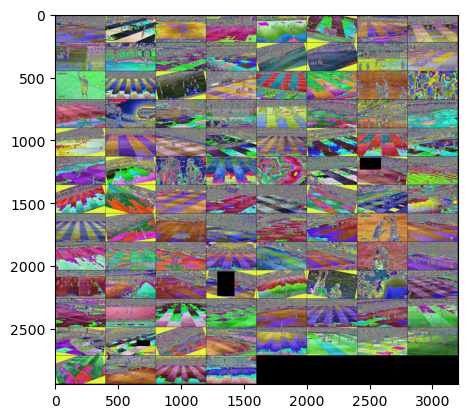

Penalty NoClass Kick-off NoClass NoClass NoClass NoClass Yellow card Yellow card Corner Yellow card Corner Goal Penalty Penalty NoClass Yellow->red card Kick-off Yellow card Penalty NoClass Kick-off Yellow card Yellow card NoClass NoClass Corner Penalty NoClass Penalty NoClass Corner NoClass NoClass Goal NoClass NoClass NoClass Kick-off Penalty NoClass Yellow card Yellow card NoClass Kick-off NoClass Penalty NoClass Kick-off Penalty NoClass NoClass Corner Penalty Corner Corner Kick-off Penalty NoClass Penalty Penalty NoClass Yellow->red card Yellow card NoClass Kick-off Goal Kick-off Penalty Corner Yellow->red card Goal Kick-off Corner Corner NoClass NoClass Yellow card NoClass Goal Goal Kick-off Kick-off Penalty NoClass Kick-off Penalty NoClass Corner Corner Penalty Corner NoClass NoClass Corner NoClass Kick-off Corner Kick-off Kick-off


In [13]:
datasetLearning = FootballDataset(data_list=data_list, transform=trans_lits)
loaderLearning = data.DataLoader(datasetLearning, batch_size = 100, shuffle= True, num_workers = 4)

images, labels = next(iter(loaderLearning))    # (perso) check ma petite faute dans le devoir 2
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[l for l in labels])

In [14]:
classes_nb = {'Corner':0, 'Goal':0, 'Penalty':0, 'Kick-off':0, 'Yellow card':0, 'Red card':0, 'Yellow->red card':0, 'NoClass':0}
for val in data_list:
    classes_nb[val[1]] += 1
print(classes_nb)
    

{'Corner': 3068, 'Goal': 3606, 'Penalty': 3000, 'Kick-off': 3060, 'Yellow card': 2406, 'Red card': 264, 'Yellow->red card': 204, 'NoClass': 7243}


### Define the dataset and the dataloader

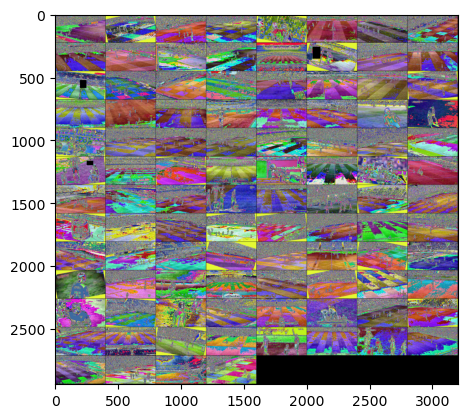

NoClass Penalty Penalty NoClass Red card Kick-off Penalty NoClass NoClass Corner Goal Goal Kick-off Corner Penalty NoClass Kick-off Goal NoClass NoClass NoClass Kick-off Yellow card NoClass Kick-off NoClass NoClass Yellow card Kick-off NoClass NoClass Yellow card Yellow card Corner NoClass Corner Corner Goal Penalty Corner Yellow card Kick-off Penalty Kick-off Yellow card NoClass NoClass Penalty Corner Penalty Corner Yellow card NoClass NoClass Corner Corner NoClass Goal NoClass Penalty Corner Goal NoClass Goal Corner Penalty Corner Penalty Penalty NoClass Goal Corner Yellow card Goal Corner Kick-off NoClass Penalty Yellow card NoClass Yellow card NoClass Corner Corner Kick-off Yellow card NoClass Goal NoClass Kick-off NoClass NoClass Yellow card Kick-off Yellow->red card NoClass Corner Penalty Corner Penalty


In [15]:
dataLearning = FootballDataset.get_images(db_path="/scratch/users/mdelabrassinne/Database/SoccerDB.db",classes = cL,limits = limits_train, type_="Training")
dataValidation = FootballDataset.get_images(db_path="/scratch/users/mdelabrassinne/Database/SoccerDB.db",classes = cL, limits = limits_test, type_="Validation")
dataTest = FootballDataset.get_images(db_path="/scratch/users/mdelabrassinne/Database/SoccerDB.db",classes = cL,limits = limits_test, type_="Test")

datasetLearning = FootballDataset(data_list=dataLearning, transform=trans_lits)
datasetValidation = FootballDataset(data_list=dataValidation, transform=[tr_base])            # no augmentation for the validation or test set
datasetTest = FootballDataset(data_list=dataTest, transform=[tr_base])


loaderLearning = data.DataLoader(datasetLearning, batch_size = 100, shuffle= True, num_workers = 4)
loaderValidation = data.DataLoader(datasetValidation, batch_size = 100, shuffle= True, num_workers = 4)
loaderTest = data.DataLoader(datasetTest, batch_size = 100, shuffle= True, num_workers = 4)



images, labels = next(iter(loaderLearning))    # (perso) check ma petite faute dans le devoir 2
show_images(utils.make_grid(images))  # should look weird due to normalization
print(*[l for l in labels])

In [16]:
device = 'cuda'
torch.cuda.empty_cache()

In [17]:
classes_nb = {'Corner':0, 'Goal':0, 'Penalty':0, 'Kick-off':0, 'Yellow card':0, 'Red card':0, 'Yellow->red card':0, 'NoClass':0}
for val in dataLearning:
    classes_nb[val[1]] += 1
print(classes_nb)

{'Corner': 3068, 'Goal': 3606, 'Penalty': 3000, 'Kick-off': 3060, 'Yellow card': 2406, 'Red card': 264, 'Yellow->red card': 204, 'NoClass': 7222}


In [18]:
classes_nb = {'Corner':0, 'Goal':0, 'Penalty':0, 'Kick-off':0, 'Yellow card':0, 'Red card':0, 'Yellow->red card':0, 'NoClass':0}
for val in dataValidation:
    classes_nb[val[1]] += 1
print(classes_nb)

{'Corner': 742, 'Goal': 636, 'Penalty': 432, 'Kick-off': 464, 'Yellow card': 620, 'Red card': 72, 'Yellow->red card': 96, 'NoClass': 547}


In [19]:
classes_nb = {'Corner':0, 'Goal':0, 'Penalty':0, 'Kick-off':0, 'Yellow card':0, 'Red card':0, 'Yellow->red card':0, 'NoClass':0}
for val in dataTest:
    classes_nb[val[1]] += 1
print(classes_nb)

{'Corner': 760, 'Goal': 658, 'Penalty': 408, 'Kick-off': 528, 'Yellow card': 564, 'Red card': 216, 'Yellow->red card': 72, 'NoClass': 486}


In [20]:
## define the model

In [21]:
# Modele simple

## resnet 

In [22]:
#model = models.resnet50(weights="IMAGENET1K_V2")
model = models.resnet152(weights="IMAGENET1K_V2")


#resnet not trained later 
for param in model.parameters():
    param.requires_grad = False

In [23]:
# MLP for classification

mlp = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 6),
    #nn.Softmax(dim=1)
)

model.fc = mlp                      # verifier 

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
v = ['Goal', 'Corner', 'Penalty', 'Kick-off', 'Yellow card', 'Red card', 'Yellow->red card', 'NoClass']
c = ['Corner', 'Goal', 'Penalty', 'Kick-off','card', 'NoClass']

def toTens(labels, classes = c):
    res = [classes.index(labels[j]) if labels[j] in c else 4 for j in range(len(labels))]
    return torch.tensor(res)
    
toTens(v, c)

tensor([1, 0, 2, 3, 4, 4, 4, 5])

In [57]:
https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb
https://youtu.be/G7GH0SeNBMA

SyntaxError: invalid syntax (4134753862.py, line 1)

In [25]:
epochs=40
n_classes=6
learning_rate=0.01
loaderLearning = loaderLearning
loaderValidation = loaderValidation
loaderTest = loaderTest
decay = .000001

In [26]:
def make():
    # Make the model
    mod = model.to(device)                                     #model variable globale

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(mod.parameters(), lr=learning_rate, weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold  = .01, threshold_mode = "abs", mode='max', factor=0.2, patience=15)
    
    return criterion, optimizer, scheduler

In [27]:
#def get_loader(config, use):
#    if(use == "Training"):
#        return config.loaderLearning
#    elif(use == "Validation"):
#        return config.loaderValidation
#    elif(use == "Test"):
#        return config.loaderTest

In [28]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

In [29]:
def train(criterion, optimizer, scheduler, test_set = True):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(loaderLearning) * epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    
    for epoch in tqdm(range(epochs)):
        for images, labels in loaderLearning:
            
            #images = images.to(device)
            labels = toTens(labels)
            
            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)
                
            torch.cuda.empty_cache()
            
        if test_set:
            acc = test()
            scheduler.step(acc)


def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

In [30]:
def test():
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        correct_class = [0 for i in range(n_classes)]
        total_class = [0 for i in range(n_classes)]
        for images, labels in loaderValidation:
            
            labels = toTens(labels)
            
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
             # Compute accuracy per class
            for i in range(len(labels)):
                label = labels[i]
                pred = predicted[i]
                total_class[label] += 1
                if label == pred:
                    correct_class[label] += 1
            torch.cuda.empty_cache()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {correct / total:%}")
        
        wandb.log({"test_accuracy": correct / total})
        
        for i in range(n_classes):
            wandb.log({f"Accuracy of {c[i]}": correct_class[i]/ total_class[i]})
        
    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")
    
    return correct / total

In [31]:
config = dict(
    epochs=40,
    classes=6,
    learning_rate=0.01,
    loaderLearning = loaderLearning,
    loaderValidation = loaderValidation,
    loaderTest = loaderTest)

In [32]:
def model_pipeline(hyperparameters, project_name = "action_spotting_ulg"):

    # tell wandb to get started
    with wandb.init(project=project_name, config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # data, and optimization problem
      criterion, optimizer, scheduler = make()

      # and use them to train the model
      train(criterion, optimizer, scheduler)

      # and test its final performance
      test()

    return model

In [33]:
sweep_config = {
    "name": "action_spotting_ulg",
    "method": "random",
    "metric": {"name": "test_accuracy", "goal": "maximize"},
    "parameters": {
        "learning_rate": {"values": [0.01]},
        "batch_size": {"values": [100]},
    }
}

In [34]:
pipe = model_pipeline(config)

  0%|          | 0/40 [00:00<?, ?it/s]

Loss after 02400 examples: 1.374
Loss after 04900 examples: 1.112
Loss after 07400 examples: 0.849
Loss after 09900 examples: 0.825
Loss after 12400 examples: 0.827
Loss after 14900 examples: 0.929
Loss after 17400 examples: 1.188
Loss after 19900 examples: 0.763
Loss after 22400 examples: 0.872
Accuracy of the model on the 3609 test images: 55.333888%


  2%|▎         | 1/40 [02:38<1:42:52, 158.26s/it]

Loss after 24830 examples: 0.743
Loss after 27330 examples: 0.782
Loss after 29830 examples: 0.751
Loss after 32330 examples: 0.787
Loss after 34830 examples: 0.598
Loss after 37330 examples: 0.582
Loss after 39830 examples: 0.775
Loss after 42330 examples: 0.739
Loss after 44830 examples: 0.675
Accuracy of the model on the 3609 test images: 65.835411%


  5%|▌         | 2/40 [05:06<1:36:26, 152.27s/it]

Loss after 47260 examples: 0.534
Loss after 49760 examples: 0.666
Loss after 52260 examples: 0.750
Loss after 54760 examples: 0.718
Loss after 57260 examples: 0.698
Loss after 59760 examples: 0.715
Loss after 62260 examples: 0.710
Loss after 64760 examples: 0.589
Loss after 67260 examples: 0.677
Accuracy of the model on the 3609 test images: 68.218343%


  8%|▊         | 3/40 [07:34<1:32:38, 150.24s/it]

Loss after 69690 examples: 0.477
Loss after 72190 examples: 0.533
Loss after 74690 examples: 0.761
Loss after 77190 examples: 0.581
Loss after 79690 examples: 0.601
Loss after 82190 examples: 0.620
Loss after 84690 examples: 0.755
Loss after 87190 examples: 0.477
Loss after 89690 examples: 0.544
Accuracy of the model on the 3609 test images: 66.251039%


 10%|█         | 4/40 [10:02<1:29:41, 149.50s/it]

Loss after 92120 examples: 0.740
Loss after 94620 examples: 0.709
Loss after 97120 examples: 0.446
Loss after 99620 examples: 0.561
Loss after 102120 examples: 0.591
Loss after 104620 examples: 0.499
Loss after 107120 examples: 0.516
Loss after 109620 examples: 0.564
Loss after 112120 examples: 0.542
Accuracy of the model on the 3609 test images: 63.119978%


 12%|█▎        | 5/40 [12:32<1:27:13, 149.54s/it]

Loss after 114550 examples: 0.613
Loss after 117050 examples: 0.457
Loss after 119550 examples: 0.681
Loss after 122050 examples: 0.514
Loss after 124550 examples: 0.506
Loss after 127050 examples: 0.707
Loss after 129550 examples: 0.589
Loss after 132050 examples: 0.650
Loss after 134550 examples: 0.707
Loss after 136980 examples: 0.744
Accuracy of the model on the 3609 test images: 63.701856%


 15%|█▌        | 6/40 [15:00<1:24:35, 149.29s/it]

Loss after 139480 examples: 0.772
Loss after 141980 examples: 0.586
Loss after 144480 examples: 0.613
Loss after 146980 examples: 0.663
Loss after 149480 examples: 0.530
Loss after 151980 examples: 0.619
Loss after 154480 examples: 0.491
Loss after 156980 examples: 0.437
Loss after 159480 examples: 0.599
Accuracy of the model on the 3609 test images: 62.676642%


 18%|█▊        | 7/40 [17:28<1:21:51, 148.83s/it]

Loss after 161910 examples: 0.527
Loss after 164410 examples: 0.558
Loss after 166910 examples: 0.476
Loss after 169410 examples: 0.530
Loss after 171910 examples: 0.482
Loss after 174410 examples: 0.688
Loss after 176910 examples: 0.704
Loss after 179410 examples: 0.576
Loss after 181910 examples: 0.444
Accuracy of the model on the 3609 test images: 63.535605%


 20%|██        | 8/40 [19:57<1:19:22, 148.83s/it]

Loss after 184340 examples: 0.452
Loss after 186840 examples: 0.416
Loss after 189340 examples: 0.422
Loss after 191840 examples: 0.534
Loss after 194340 examples: 0.620
Loss after 196840 examples: 0.743
Loss after 199340 examples: 0.661
Loss after 201840 examples: 0.632
Loss after 204340 examples: 0.701
Accuracy of the model on the 3609 test images: 67.719590%


 22%|██▎       | 9/40 [22:25<1:16:42, 148.45s/it]

Loss after 206770 examples: 0.536
Loss after 209270 examples: 0.615
Loss after 211770 examples: 0.487
Loss after 214270 examples: 0.363
Loss after 216770 examples: 0.596
Loss after 219270 examples: 0.507
Loss after 221770 examples: 0.661
Loss after 224270 examples: 0.497
Loss after 226770 examples: 0.350
Accuracy of the model on the 3609 test images: 62.787476%


 25%|██▌       | 10/40 [24:51<1:13:53, 147.78s/it]

Loss after 229200 examples: 0.585
Loss after 231700 examples: 0.356
Loss after 234200 examples: 0.625
Loss after 236700 examples: 0.424
Loss after 239200 examples: 0.472
Loss after 241700 examples: 0.504
Loss after 244200 examples: 0.498
Loss after 246700 examples: 0.532
Loss after 249200 examples: 0.418
Accuracy of the model on the 3609 test images: 64.865614%


 28%|██▊       | 11/40 [27:18<1:11:17, 147.49s/it]

Loss after 251630 examples: 0.424
Loss after 254130 examples: 0.481
Loss after 256630 examples: 0.587
Loss after 259130 examples: 0.447
Loss after 261630 examples: 0.372
Loss after 264130 examples: 0.412
Loss after 266630 examples: 0.449
Loss after 269130 examples: 0.419
Loss after 271630 examples: 0.582
Accuracy of the model on the 3609 test images: 64.145193%


 30%|███       | 12/40 [29:44<1:08:39, 147.13s/it]

Loss after 274060 examples: 0.372
Loss after 276560 examples: 0.527
Loss after 279060 examples: 0.628
Loss after 281560 examples: 0.271
Loss after 284060 examples: 0.388
Loss after 286560 examples: 0.471
Loss after 289060 examples: 0.504
Loss after 291560 examples: 0.432
Loss after 294060 examples: 0.357
Loss after 296560 examples: 0.410
Accuracy of the model on the 3609 test images: 65.696869%


 32%|███▎      | 13/40 [32:10<1:06:05, 146.87s/it]

Loss after 298990 examples: 0.391
Loss after 301490 examples: 0.475
Loss after 303990 examples: 0.375
Loss after 306490 examples: 0.286
Loss after 308990 examples: 0.459
Loss after 311490 examples: 0.541
Loss after 313990 examples: 0.712
Loss after 316490 examples: 0.416
Loss after 318990 examples: 0.610
Accuracy of the model on the 3609 test images: 66.029371%


 35%|███▌      | 14/40 [34:38<1:03:42, 147.04s/it]

Loss after 321420 examples: 0.306
Loss after 323920 examples: 0.372
Loss after 326420 examples: 0.439
Loss after 328920 examples: 0.423
Loss after 331420 examples: 0.532
Loss after 333920 examples: 0.346
Loss after 336420 examples: 0.663
Loss after 338920 examples: 0.347
Loss after 341420 examples: 0.393
Accuracy of the model on the 3609 test images: 65.558326%


 38%|███▊      | 15/40 [37:05<1:01:13, 146.95s/it]

Loss after 343850 examples: 0.342
Loss after 346350 examples: 0.434
Loss after 348850 examples: 0.437
Loss after 351350 examples: 0.429
Loss after 353850 examples: 0.420
Loss after 356350 examples: 0.420
Loss after 358850 examples: 0.493
Loss after 361350 examples: 0.468
Loss after 363850 examples: 0.357
Accuracy of the model on the 3609 test images: 63.563314%


 40%|████      | 16/40 [39:31<58:41, 146.72s/it]  

Loss after 366280 examples: 0.319
Loss after 368780 examples: 0.315
Loss after 371280 examples: 0.462
Loss after 373780 examples: 0.569
Loss after 376280 examples: 0.370
Loss after 378780 examples: 0.352
Loss after 381280 examples: 0.285
Loss after 383780 examples: 0.355
Loss after 386280 examples: 0.410
Accuracy of the model on the 3609 test images: 67.553339%


 42%|████▎     | 17/40 [41:57<56:10, 146.54s/it]

Loss after 388710 examples: 0.501
Loss after 391210 examples: 0.407
Loss after 393710 examples: 0.438
Loss after 396210 examples: 0.328
Loss after 398710 examples: 0.391
Loss after 401210 examples: 0.325
Loss after 403710 examples: 0.295
Loss after 406210 examples: 0.540
Loss after 408710 examples: 0.332
Accuracy of the model on the 3609 test images: 64.782488%


 45%|████▌     | 18/40 [44:23<53:43, 146.54s/it]

Loss after 411140 examples: 0.404
Loss after 413640 examples: 0.365
Loss after 416140 examples: 0.433
Loss after 418640 examples: 0.484
Loss after 421140 examples: 0.465
Loss after 423640 examples: 0.355
Loss after 426140 examples: 0.450
Loss after 428640 examples: 0.427
Loss after 431140 examples: 0.566
Loss after 433640 examples: 0.457
Accuracy of the model on the 3609 test images: 62.122472%


 48%|████▊     | 19/40 [46:49<51:14, 146.38s/it]

Loss after 436070 examples: 0.266
Loss after 438570 examples: 0.291
Loss after 441070 examples: 0.396
Loss after 443570 examples: 0.409
Loss after 446070 examples: 0.407
Loss after 448570 examples: 0.349
Loss after 451070 examples: 0.454
Loss after 453570 examples: 0.290
Loss after 456070 examples: 0.385
Accuracy of the model on the 3609 test images: 65.890828%


 50%|█████     | 20/40 [49:16<48:50, 146.50s/it]

Loss after 458500 examples: 0.245
Loss after 461000 examples: 0.549
Loss after 463500 examples: 0.322
Loss after 466000 examples: 0.325
Loss after 468500 examples: 0.301
Loss after 471000 examples: 0.352
Loss after 473500 examples: 0.374
Loss after 476000 examples: 0.260
Loss after 478500 examples: 0.388
Accuracy of the model on the 3609 test images: 65.447492%


 52%|█████▎    | 21/40 [51:43<46:22, 146.44s/it]

Loss after 480930 examples: 0.421
Loss after 483430 examples: 0.259
Loss after 485930 examples: 0.356
Loss after 488430 examples: 0.281
Loss after 490930 examples: 0.370
Loss after 493430 examples: 0.345
Loss after 495930 examples: 0.428
Loss after 498430 examples: 0.351
Loss after 500930 examples: 0.420
Accuracy of the model on the 3609 test images: 65.558326%


 55%|█████▌    | 22/40 [54:09<43:58, 146.57s/it]

Loss after 503360 examples: 0.440
Loss after 505860 examples: 0.377
Loss after 508360 examples: 0.398
Loss after 510860 examples: 0.366
Loss after 513360 examples: 0.326
Loss after 515860 examples: 0.209
Loss after 518360 examples: 0.527
Loss after 520860 examples: 0.402
Loss after 523360 examples: 0.313
Accuracy of the model on the 3609 test images: 65.946245%


 57%|█████▊    | 23/40 [56:36<41:31, 146.54s/it]

Loss after 525790 examples: 0.282
Loss after 528290 examples: 0.334
Loss after 530790 examples: 0.310
Loss after 533290 examples: 0.290
Loss after 535790 examples: 0.399
Loss after 538290 examples: 0.286
Loss after 540790 examples: 0.261
Loss after 543290 examples: 0.311
Loss after 545790 examples: 0.257
Accuracy of the model on the 3609 test images: 65.336658%


 60%|██████    | 24/40 [59:03<39:06, 146.69s/it]

Loss after 548220 examples: 0.234
Loss after 550720 examples: 0.399
Loss after 553220 examples: 0.357
Loss after 555720 examples: 0.389
Loss after 558220 examples: 0.264
Loss after 560720 examples: 0.278
Loss after 563220 examples: 0.340
Loss after 565720 examples: 0.320
Loss after 568220 examples: 0.363
Loss after 570720 examples: 0.408
Accuracy of the model on the 3609 test images: 66.361873%


 62%|██████▎   | 25/40 [1:01:30<36:40, 146.69s/it]

Loss after 573150 examples: 0.207
Loss after 575650 examples: 0.183
Loss after 578150 examples: 0.331
Loss after 580650 examples: 0.347
Loss after 583150 examples: 0.212
Loss after 585650 examples: 0.310
Loss after 588150 examples: 0.414
Loss after 590650 examples: 0.410
Loss after 593150 examples: 0.258
Accuracy of the model on the 3609 test images: 64.727071%


 65%|██████▌   | 26/40 [1:03:56<34:11, 146.54s/it]

Loss after 595580 examples: 0.207
Loss after 598080 examples: 0.249
Loss after 600580 examples: 0.467
Loss after 603080 examples: 0.324
Loss after 605580 examples: 0.376
Loss after 608080 examples: 0.366
Loss after 610580 examples: 0.260
Loss after 613080 examples: 0.404
Loss after 615580 examples: 0.283
Accuracy of the model on the 3609 test images: 65.973954%


 68%|██████▊   | 27/40 [1:06:22<31:45, 146.58s/it]

Loss after 618010 examples: 0.377
Loss after 620510 examples: 0.267
Loss after 623010 examples: 0.421
Loss after 625510 examples: 0.214
Loss after 628010 examples: 0.138
Loss after 630510 examples: 0.407
Loss after 633010 examples: 0.416
Loss after 635510 examples: 0.244
Loss after 638010 examples: 0.218
Accuracy of the model on the 3609 test images: 65.835411%


 70%|███████   | 28/40 [1:08:49<29:19, 146.63s/it]

Loss after 640440 examples: 0.269
Loss after 642940 examples: 0.462
Loss after 645440 examples: 0.344
Loss after 647940 examples: 0.318
Loss after 650440 examples: 0.330
Loss after 652940 examples: 0.354
Loss after 655440 examples: 0.275
Loss after 657940 examples: 0.288
Loss after 660440 examples: 0.242
Accuracy of the model on the 3609 test images: 65.669160%


 72%|███████▎  | 29/40 [1:11:17<26:55, 146.87s/it]

Loss after 662870 examples: 0.240
Loss after 665370 examples: 0.317
Loss after 667870 examples: 0.307
Loss after 670370 examples: 0.189
Loss after 672870 examples: 0.279
Loss after 675370 examples: 0.373
Loss after 677870 examples: 0.284
Loss after 680370 examples: 0.235
Loss after 682870 examples: 0.283
Accuracy of the model on the 3609 test images: 64.394569%


 75%|███████▌  | 30/40 [1:13:43<24:27, 146.75s/it]

Loss after 685300 examples: 0.274
Loss after 687800 examples: 0.317
Loss after 690300 examples: 0.380
Loss after 692800 examples: 0.293
Loss after 695300 examples: 0.238
Loss after 697800 examples: 0.321
Loss after 700300 examples: 0.243
Loss after 702800 examples: 0.291
Loss after 705300 examples: 0.365
Loss after 707730 examples: 0.228
Accuracy of the model on the 3609 test images: 66.195622%


 78%|███████▊  | 31/40 [1:16:09<21:59, 146.62s/it]

Loss after 710230 examples: 0.246
Loss after 712730 examples: 0.241
Loss after 715230 examples: 0.302
Loss after 717730 examples: 0.265
Loss after 720230 examples: 0.218
Loss after 722730 examples: 0.396
Loss after 725230 examples: 0.277
Loss after 727730 examples: 0.397
Loss after 730230 examples: 0.256
Accuracy of the model on the 3609 test images: 63.757273%


 80%|████████  | 32/40 [1:18:36<19:33, 146.67s/it]

Loss after 732660 examples: 0.325
Loss after 735160 examples: 0.227
Loss after 737660 examples: 0.371
Loss after 740160 examples: 0.407
Loss after 742660 examples: 0.281
Loss after 745160 examples: 0.195
Loss after 747660 examples: 0.336
Loss after 750160 examples: 0.445
Loss after 752660 examples: 0.256
Accuracy of the model on the 3609 test images: 64.727071%


 82%|████████▎ | 33/40 [1:21:03<17:06, 146.58s/it]

Loss after 755090 examples: 0.217
Loss after 757590 examples: 0.228
Loss after 760090 examples: 0.355
Loss after 762590 examples: 0.306
Loss after 765090 examples: 0.263
Loss after 767590 examples: 0.252
Loss after 770090 examples: 0.257
Loss after 772590 examples: 0.254
Loss after 775090 examples: 0.255
Accuracy of the model on the 3609 test images: 63.895816%


 85%|████████▌ | 34/40 [1:24:17<16:05, 161.00s/it]

Loss after 777520 examples: 0.207
Loss after 780020 examples: 0.378
Loss after 782520 examples: 0.407
Loss after 785020 examples: 0.295
Loss after 787520 examples: 0.330
Loss after 790020 examples: 0.366
Loss after 792520 examples: 0.184
Loss after 795020 examples: 0.296
Loss after 797520 examples: 0.330
Accuracy of the model on the 3609 test images: 65.004156%


 88%|████████▊ | 35/40 [1:26:45<13:04, 156.95s/it]

Loss after 799950 examples: 0.473
Loss after 802450 examples: 0.204
Loss after 804950 examples: 0.240
Loss after 807450 examples: 0.250
Loss after 809950 examples: 0.323
Loss after 812450 examples: 0.365
Loss after 814950 examples: 0.346
Loss after 817450 examples: 0.350
Loss after 819950 examples: 0.261
Accuracy of the model on the 3609 test images: 64.422278%


 90%|█████████ | 36/40 [1:29:12<10:15, 153.97s/it]

Loss after 822380 examples: 0.180
Loss after 824880 examples: 0.213
Loss after 827380 examples: 0.301
Loss after 829880 examples: 0.327
Loss after 832380 examples: 0.368
Loss after 834880 examples: 0.246
Loss after 837380 examples: 0.270
Loss after 839880 examples: 0.213
Loss after 842380 examples: 0.354
Accuracy of the model on the 3609 test images: 64.006650%


 92%|█████████▎| 37/40 [1:31:39<07:35, 151.95s/it]

Loss after 844810 examples: 0.220
Loss after 847310 examples: 0.291
Loss after 849810 examples: 0.060
Loss after 852310 examples: 0.302
Loss after 854810 examples: 0.309
Loss after 857310 examples: 0.272
Loss after 859810 examples: 0.309
Loss after 862310 examples: 0.263
Loss after 864810 examples: 0.230
Loss after 867310 examples: 0.220
Accuracy of the model on the 3609 test images: 64.172901%


 95%|█████████▌| 38/40 [1:34:06<05:00, 150.38s/it]

Loss after 869740 examples: 0.210
Loss after 872240 examples: 0.300
Loss after 874740 examples: 0.279
Loss after 877240 examples: 0.416
Loss after 879740 examples: 0.188
Loss after 882240 examples: 0.189
Loss after 884740 examples: 0.284
Loss after 887240 examples: 0.242
Loss after 889740 examples: 0.259
Accuracy of the model on the 3609 test images: 64.117484%


 98%|█████████▊| 39/40 [1:36:32<02:29, 149.11s/it]

Loss after 892170 examples: 0.171
Loss after 894670 examples: 0.249
Loss after 897170 examples: 0.253
Loss after 899670 examples: 0.226
Loss after 902170 examples: 0.313
Loss after 904670 examples: 0.191
Loss after 907170 examples: 0.150
Loss after 909670 examples: 0.218
Loss after 912170 examples: 0.303
Accuracy of the model on the 3609 test images: 64.200610%


100%|██████████| 40/40 [1:38:59<00:00, 148.49s/it]


Accuracy of the model on the 3609 test images: 64.200610%


In [35]:
torch.save(model.state_dict(), "resnet152_test_konoha.pt")

In [115]:
mdoel2 = models.resnet152(weights="IMAGENET1K_V2")

#resnet not trained later 
for param in mdoel2.parameters():
    param.requires_grad = False
    
# MLP for classification

mlp = nn.Sequential(
    nn.Linear(mdoel2.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 6),
    #nn.Softmax(dim=1)
)

mdoel2.fc = mlp                      # verifier 

mdoel2.load_state_dict(torch.load('model_basic_mais_tenebreux.pt'))
print(mdoel2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [110]:
#mdoel2 = torch.load("model_basic_mais_tenebreux.pt")
#print(mdoel2)

OrderedDict([('conv1.weight', tensor([[[[-1.5234e-02,  4.8151e-02, -6.5250e-02,  ...,  3.8342e-02,
            6.5269e-02, -1.9087e-03],
          [ 5.0071e-02,  1.2099e-02, -2.5142e-01,  ...,  8.7146e-02,
            8.9024e-02, -7.0703e-03],
          [ 8.3375e-02, -1.3935e-01, -4.6370e-01,  ...,  2.0106e-01,
            9.1207e-02,  6.7271e-03],
          ...,
          [-2.1216e-02, -2.3312e-01, -1.1718e-01,  ...,  2.6633e-01,
            1.6465e-02, -1.0811e-01],
          [-6.6910e-02, -1.4574e-01,  6.7389e-03,  ...,  4.7456e-02,
           -9.8735e-02, -1.1817e-01],
          [-6.5149e-02, -4.2933e-02,  8.9413e-02,  ..., -3.2629e-02,
           -1.0755e-01, -2.8073e-02]],

         [[ 1.4876e-01,  1.4249e-01, -1.4551e-01,  ..., -6.1017e-02,
            4.0947e-02,  1.8052e-02],
          [ 1.9143e-01, -3.3484e-02, -5.3884e-01,  ...,  3.2720e-02,
            1.3359e-01,  2.5714e-02],
          [ 1.2938e-01, -4.0243e-01, -8.5109e-01,  ...,  3.4838e-01,
            2.6148e-01,  1.0

In [33]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

# Train the model
num_epochs = 1
for epoch in range(num_epochs):
    for images, labels in tqdm(loaderLearning):
        images = images.to(device)
        val = toTens(labels).to(device)
        
        # Forward pass
        outputs = model(images)
        print(outputs)
        #print(labels)
        loss = loss_fn(outputs, val)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #val = val.to("cpu")
        #images = images.to("cpu")

    # Print training loss after every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

  0%|          | 1/561 [00:10<1:39:57, 10.71s/it]

tensor([[-7.6926e-03,  4.0952e-02,  7.0218e-02, -5.9507e-02, -6.9008e-02,
         -1.1090e-02],
        [-2.7363e-02,  1.1313e-02,  1.0950e-01, -7.6767e-02, -9.3570e-02,
         -1.9153e-02],
        [-2.3892e-02,  5.4573e-02,  6.3474e-02, -8.8908e-02, -6.2526e-02,
         -2.0565e-02],
        [-3.1708e-02,  3.7759e-02,  9.3749e-02, -6.9352e-02, -8.1526e-02,
         -1.8807e-02],
        [-1.2822e-02,  2.6701e-02,  8.5085e-02, -6.0728e-02, -8.4837e-02,
         -1.7480e-02],
        [-4.6713e-02,  3.8867e-02,  7.7105e-02, -7.5869e-02, -1.0740e-01,
         -4.8005e-02],
        [-1.8918e-02,  5.3506e-02,  9.2815e-02, -6.4329e-02, -9.2225e-02,
          1.1356e-02],
        [-1.4060e-02,  3.2721e-02,  1.0585e-01, -7.2917e-02, -8.6972e-02,
          5.7580e-04],
        [-1.3155e-02,  4.7474e-02,  8.4620e-02, -5.9302e-02, -7.3357e-02,
         -1.1931e-02],
        [ 7.5849e-04,  2.3105e-02,  6.7556e-02, -7.3781e-02, -8.3129e-02,
         -1.0520e-02],
        [-1.4365e-02,  2.8060e

  0%|          | 2/561 [00:11<43:41,  4.69s/it]  

tensor([[ 4.9524e-02,  1.3513e-02, -1.8581e-01, -1.4527e-02,  8.3805e-04,
         -5.5110e-03],
        [ 2.0590e-02,  1.2116e-02, -7.9334e-02, -3.5898e-02,  4.4978e-02,
          1.5166e-02],
        [ 3.3941e-02,  1.6238e-02, -6.3511e-02, -2.2474e-02, -4.3866e-03,
          2.6771e-02],
        [ 3.2913e-02,  5.7498e-03, -5.8270e-02, -4.4947e-02,  1.1370e-02,
          1.4716e-02],
        [ 4.1480e-02,  7.2223e-03, -1.1995e-01, -6.7769e-03, -9.9421e-03,
          1.5575e-02],
        [ 3.9797e-02,  8.4204e-03, -6.7331e-02, -3.3686e-02,  1.1116e-02,
          7.6721e-03],
        [ 4.0524e-02,  1.7272e-02, -7.0850e-02, -3.2655e-02, -1.7506e-02,
          7.6511e-03],
        [ 5.6383e-02,  2.8938e-02, -1.6142e-01,  4.2890e-02, -4.7860e-03,
          3.4755e-02],
        [ 7.5363e-02,  3.9460e-03, -9.5270e-02, -1.3140e-02, -2.3900e-02,
         -1.5303e-02],
        [ 5.3449e-02,  2.8201e-02, -9.4924e-02, -7.9791e-03, -5.5252e-03,
          7.1160e-03],
        [ 5.0222e-02,  3.4005e

  1%|          | 3/561 [00:11<25:43,  2.77s/it]

tensor([[ 0.1609,  0.0607, -0.3283,  0.0393,  0.0251, -0.0201],
        [ 0.1234,  0.0090, -0.4126,  0.0381,  0.1639, -0.0504],
        [ 0.1494,  0.0633, -0.2806,  0.0543,  0.0096, -0.0042],
        [ 0.2033,  0.0685, -0.4660,  0.0523,  0.1080, -0.0297],
        [ 0.1921,  0.0579, -0.4688,  0.1137,  0.1001,  0.0038],
        [ 0.0923,  0.0431, -0.3050,  0.1104,  0.0428, -0.0073],
        [ 0.2147,  0.0599, -0.4211,  0.0523,  0.0729, -0.0154],
        [ 0.1912,  0.0636, -0.5073,  0.1357,  0.1105,  0.0194],
        [ 0.2300,  0.0873, -0.5226,  0.1398,  0.0561, -0.0013],
        [ 0.1886,  0.0696, -0.3617,  0.0823,  0.0296, -0.0219],
        [ 0.2035,  0.0570, -0.4974,  0.1682,  0.0812, -0.0197],
        [ 0.1489,  0.0607, -0.4211,  0.1280,  0.0725,  0.0229],
        [ 0.2502,  0.0718, -0.5246,  0.1793,  0.0688, -0.0020],
        [ 0.1331, -0.0131, -0.4010,  0.0327,  0.1713, -0.0485],
        [ 0.1949,  0.0548, -0.3868,  0.0853,  0.0457, -0.0431],
        [ 0.2232,  0.0375, -0.5059,  0.0

  1%|          | 4/561 [00:12<17:24,  1.88s/it]

tensor([[ 0.3447,  0.0416, -0.8556,  0.3340,  0.1568, -0.0589],
        [ 0.3096,  0.0507, -0.7122,  0.2498,  0.1235, -0.0473],
        [ 0.1661,  0.0048, -0.5122,  0.1321,  0.1904, -0.0936],
        [ 0.1560,  0.0164, -0.3894,  0.1058,  0.1317, -0.0445],
        [ 0.2252,  0.0300, -0.6144,  0.1780,  0.2078, -0.0797],
        [ 0.3450,  0.0878, -0.7272,  0.2560,  0.0799, -0.0357],
        [ 0.3185,  0.0565, -0.6577,  0.2446,  0.0995, -0.0505],
        [ 0.2925,  0.0697, -0.5610,  0.1478,  0.0465, -0.0375],
        [ 0.4073,  0.1034, -0.9913,  0.3014,  0.1673, -0.0635],
        [ 0.3102,  0.0527, -0.8233,  0.3513,  0.1566, -0.0305],
        [ 0.2171,  0.0032, -0.6626,  0.1742,  0.2552, -0.0966],
        [ 0.3440,  0.0701, -0.7886,  0.2279,  0.1491, -0.0737],
        [ 0.2322,  0.0420, -0.5175,  0.1655,  0.0940, -0.0557],
        [ 0.3139,  0.0698, -0.7567,  0.2252,  0.1493, -0.0514],
        [ 0.1697,  0.0306, -0.4287,  0.1007,  0.1341, -0.0622],
        [ 0.3069,  0.0815, -0.7300,  0.2

  1%|          | 5/561 [00:12<12:54,  1.39s/it]

tensor([[ 4.6913e-01,  9.2546e-02, -1.4164e+00,  5.9404e-01,  3.0853e-01,
          1.0774e-03],
        [ 4.4685e-01,  1.3423e-01, -1.3762e+00,  4.8139e-01,  2.9215e-01,
          3.1573e-03],
        [ 4.0952e-01,  1.0543e-01, -1.2088e+00,  5.6425e-01,  2.1739e-01,
          2.8011e-03],
        [ 5.6586e-01,  1.5327e-01, -1.6025e+00,  7.1435e-01,  2.8997e-01,
          2.5973e-02],
        [ 5.1819e-01,  1.1933e-01, -1.4861e+00,  6.7457e-01,  2.7368e-01,
          2.2654e-02],
        [ 5.8165e-01,  1.5787e-01, -1.4412e+00,  5.9503e-01,  2.0745e-01,
          2.8638e-03],
        [ 3.0694e-01,  6.2916e-02, -9.3210e-01,  2.1136e-01,  3.1770e-01,
         -7.3492e-02],
        [ 4.2411e-01,  1.0681e-01, -9.7175e-01,  3.7718e-01,  1.0806e-01,
         -1.4806e-02],
        [ 1.9225e-01,  2.0659e-02, -6.4657e-01,  1.8483e-01,  2.6531e-01,
         -7.1743e-02],
        [ 1.7755e-01,  1.1719e-02, -5.6477e-01,  1.1074e-01,  2.1001e-01,
         -6.5531e-03],
        [ 5.2472e-01,  1.6455e

  1%|          | 6/561 [00:13<10:01,  1.08s/it]

tensor([[ 0.5906,  0.2657, -1.8069,  0.5455,  0.2790,  0.1478],
        [ 0.4117,  0.1874, -1.2756,  0.3658,  0.2253,  0.1237],
        [ 0.4692,  0.1777, -1.4029,  0.5925,  0.2106,  0.1401],
        [ 0.4286,  0.1864, -1.3473,  0.3678,  0.2470,  0.1126],
        [ 0.2142,  0.0325, -0.8338,  0.1924,  0.3123,  0.0101],
        [ 0.5203,  0.2062, -1.7190,  0.5582,  0.3289,  0.1713],
        [ 0.3831,  0.1462, -1.2075,  0.5263,  0.1520,  0.1156],
        [ 0.4528,  0.1630, -1.5752,  0.7022,  0.2386,  0.2041],
        [ 0.5470,  0.2090, -1.7308,  0.5375,  0.3367,  0.1307],
        [ 0.3185,  0.0553, -1.1846,  0.2233,  0.4003,  0.0168],
        [ 0.4912,  0.2052, -1.4464,  0.4769,  0.2084,  0.1345],
        [ 0.4773,  0.1847, -1.5724,  0.6048,  0.2684,  0.1656],
        [ 0.4477,  0.1535, -1.4294,  0.7376,  0.1762,  0.1492],
        [ 0.4204,  0.1644, -1.0908,  0.3972,  0.1206,  0.0940],
        [ 0.5834,  0.2498, -1.8075,  0.7762,  0.2157,  0.2219],
        [ 0.5503,  0.2033, -1.5156,  0.5

  1%|          | 6/561 [00:13<21:03,  2.28s/it]


KeyboardInterrupt: 

In [37]:
#wandb.init()
wandb.unwatch(model)
wandb.finish()

In [69]:
model = model.to("cpu")
molde = model.to(device)

In [84]:
outputs = np.array([])
gtruths = np.array([])
for images, labels in tqdm(loaderTest):
    images = images.to(device)
    val = toTens(labels).to(device)

    # Forward pass
    out = model(images)
    out = out.to("cpu").detach().numpy()
    #print(np.argmax(out, axis = 1))
    outputs = np.hstack((outputs, np.argmax(out, axis = 1)))

    gtruths = np.hstack((gtruths, toTens(labels)))
    torch.cuda.empty_cache()
    #print(gtruths)
    #print(outputs)
    #print(outputs.shape)
    #outputs = np.hstack(outputs)


100%|██████████| 38/38 [00:39<00:00,  1.03s/it]


Exemple conf mat

In [ ]:
pred = np.random.randint(0, 5, 50)
gtruth = np.random.randint(0,5,50)


classes = ["class1", "class2", "class3", "class4", "class5"]

In [88]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

[[566  96   7   2   8  81]
 [ 66 483  38   4   6  61]
 [ 51 163 166   0   0  28]
 [  5   4   0 458  11  50]
 [ 13  13   7  15 608 196]
 [ 55  82   2  20  46 334]]


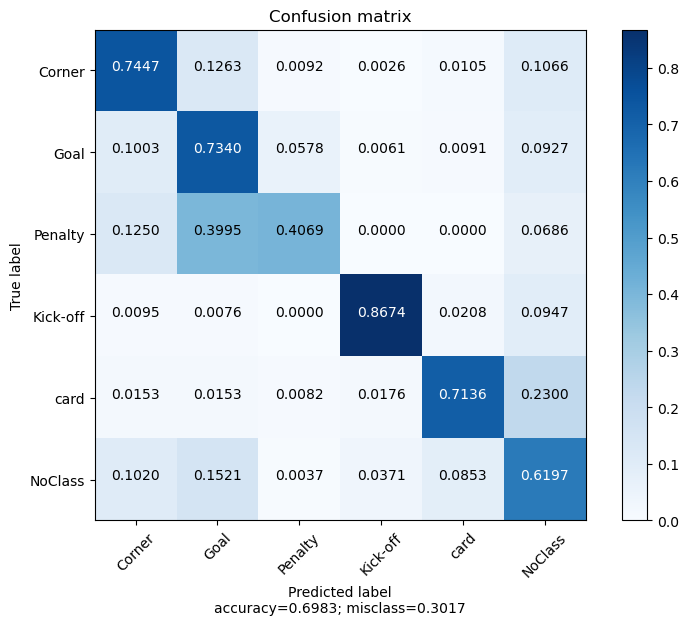

In [89]:
from sklearn.metrics import confusion_matrix
import itertools

conf_matrix = confusion_matrix(gtruths, outputs)
print(conf_matrix)
plot_confusion_matrix(conf_matrix, c, normalize=True)